## Model Exercises - Based on Walkthrough
`Corey Solitaire`   
10.30.2020   

In [1]:
import requests
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import os
from env import host, user, password
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

## Wrangle:

In [2]:
# Call CSV
df = pd.read_csv('time_series_project.csv')
# Convert to Datetime
df.date = pd.to_datetime(df.date)
# Reset Index
df = df.set_index('date').sort_index()
df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [3]:
df.shape

(247, 9)

In [4]:
df.head(125)

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0
...,...,...,...,...,...,...,...,...,...
2018-08-24,2168.0,68.0,0.03,0.0,994.0,7.0,0.0,0.0,32.0
2018-08-25,3719.0,4054.0,1.91,7.0,1190.0,204.0,23.0,23.0,1731.0
2018-08-26,799.0,207.0,0.10,1.0,28.0,13.0,0.0,0.0,51.0


<div class="alert alert-block alert-info"><b></b></div>

# Explore:

Split:

    1. We will use the training proprtion method to split
    2. Identify lenght of df, mult by train_prop to get the number of rows. x = train_prop * 100
    3. Select row indicies
    4. Return train and test dataframes

<div class="alert alert-block alert-info"><b></b></div>

In [5]:
train_size = int(len(df)*.5)
train_size

123

In [6]:
validate_size = int(len(df)*.3)
validate_size

74

In [7]:
test_size = int(len(df) - train_size - validate_size)
test_size

50

In [8]:
# Verify all data is accounted for
validate_end_index = train_size + validate_size
validate_end_index

197

#### Use Values to Split Data Frame

In [9]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

#### Verify Splits

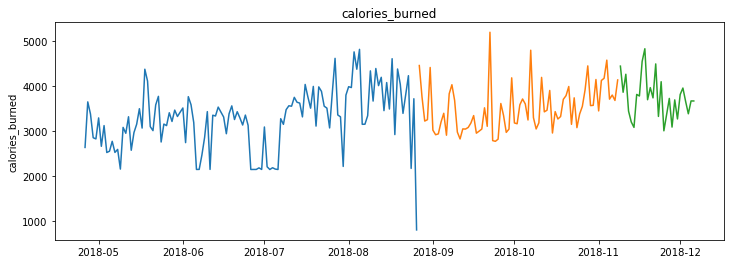

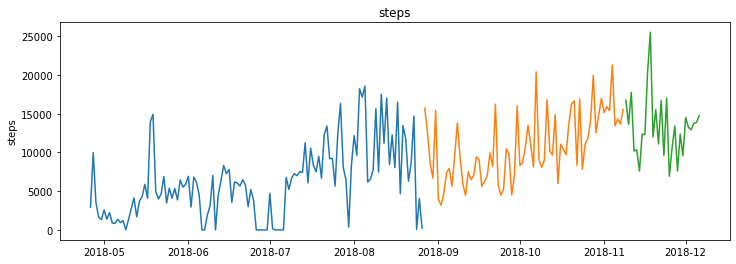

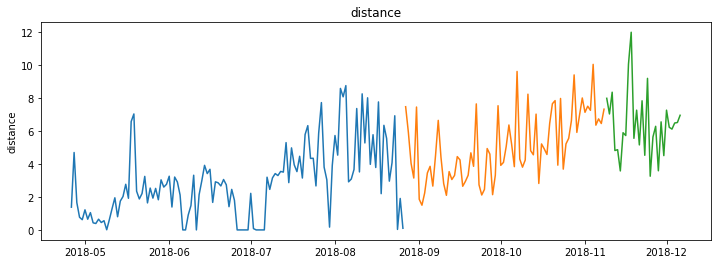

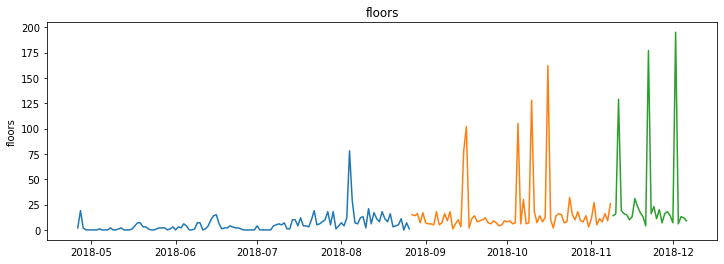

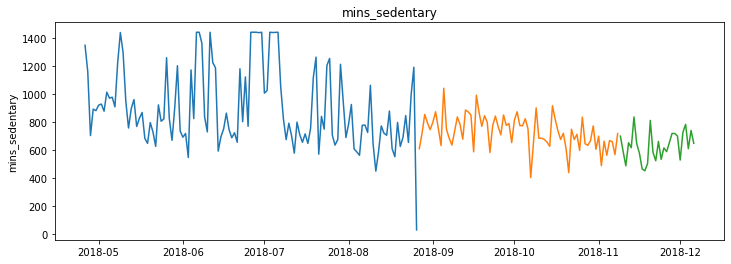

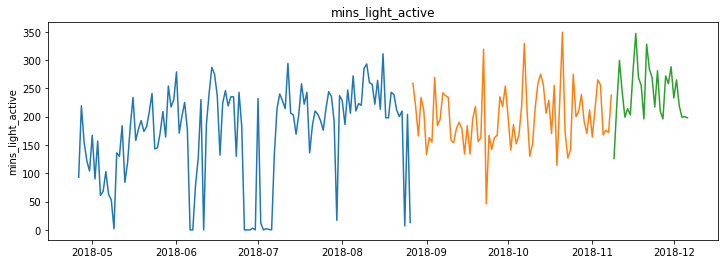

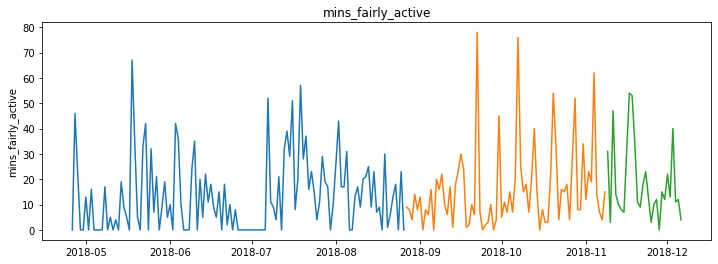

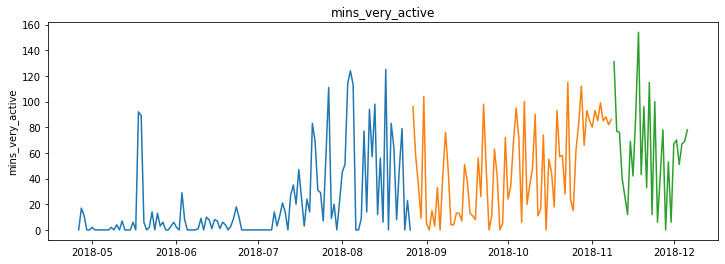

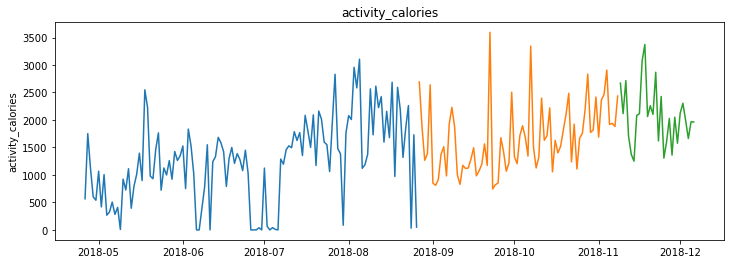

In [10]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### Create Evaluate Functions

In [11]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [12]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [13]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [14]:
# Verify Functions Work Properly
eval_df

,model_type,target_var,rmse


<div class="alert alert-block alert-info"><b></b></div>

# Forecast

Forecasting is another word for predicting time series data.

    Last Observed Value
    Simple Average
    Moving Average
    Holt's Linear Trend
    Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

## Last Observed Value

<div class="alert alert-block alert-info"><b></b></div>

In [15]:
list = list(train.columns)
list

['calories_burned',
 'steps',
 'distance',
 'floors',
 'mins_sedentary',
 'mins_light_active',
 'mins_fairly_active',
 'mins_very_active',
 'activity_calories']

#### Make Predictions

In [16]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'][-1:][0], 2)
# steps prediction
steps = round(train['steps'][-1:][0], 2)
# distance prediction
distance = round(train['distance'][-1:][0], 2)
# floors prediction
floors = round(train['floors'][-1:][0], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'][-1:][0], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'][-1:][0], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'][-1:][0], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'][-1:][0], 2)
# activity_calories
activity_calories = round(train['activity_calories'][-1:][0], 2)

#### Apply Predictions to Observations

In [17]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-27,799.0,207.0,0.1,1.0,28.0,13.0,0.0,0.0,51.0
2018-08-28,799.0,207.0,0.1,1.0,28.0,13.0,0.0,0.0,51.0
2018-08-29,799.0,207.0,0.1,1.0,28.0,13.0,0.0,0.0,51.0
2018-08-30,799.0,207.0,0.1,1.0,28.0,13.0,0.0,0.0,51.0
2018-08-31,799.0,207.0,0.1,1.0,28.0,13.0,0.0,0.0,51.0


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 2754


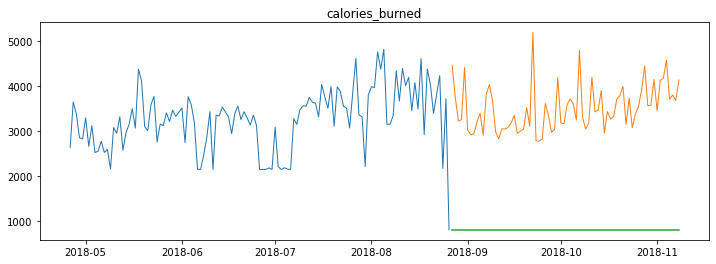

steps -- RMSE: 11348


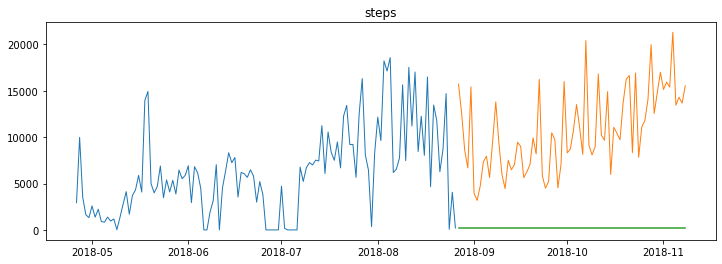

distance -- RMSE: 5


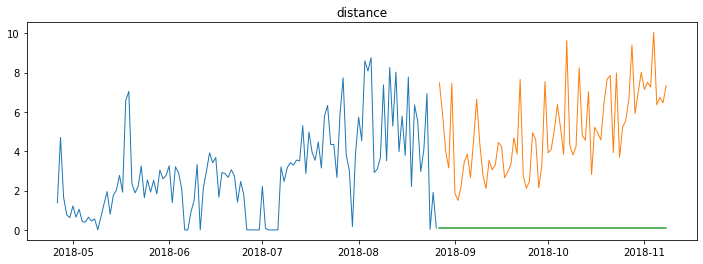

floors -- RMSE: 32


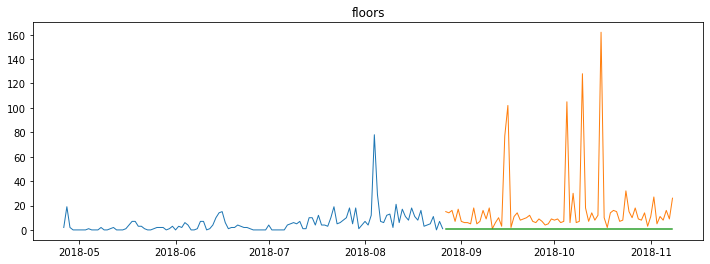

mins_sedentary -- RMSE: 711


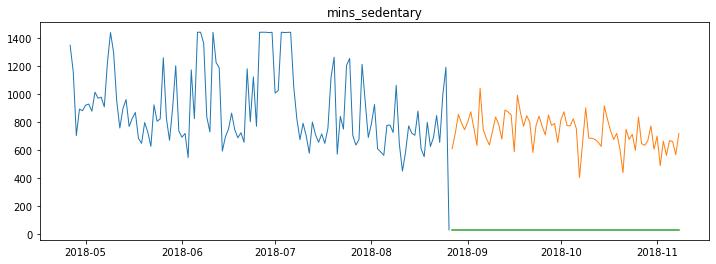

mins_light_active -- RMSE: 193


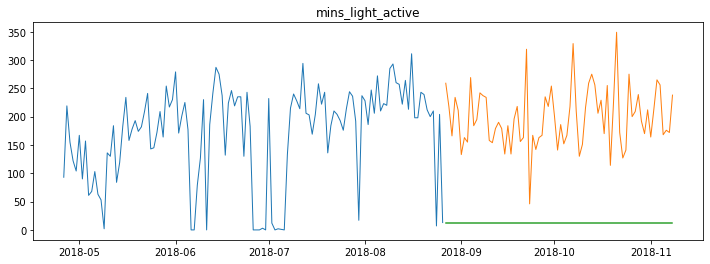

mins_fairly_active -- RMSE: 23


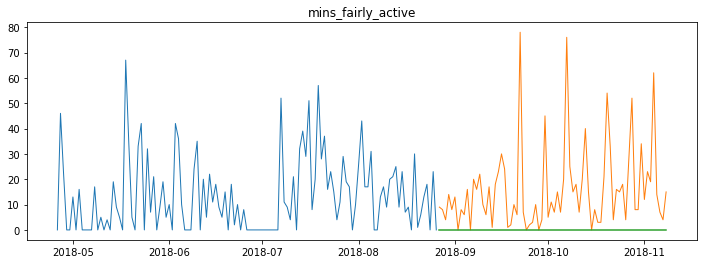

mins_very_active -- RMSE: 59


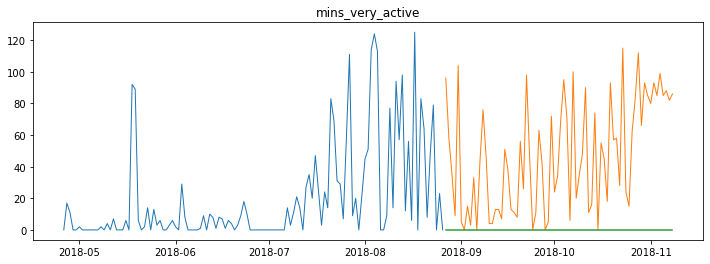

activity_calories -- RMSE: 1726


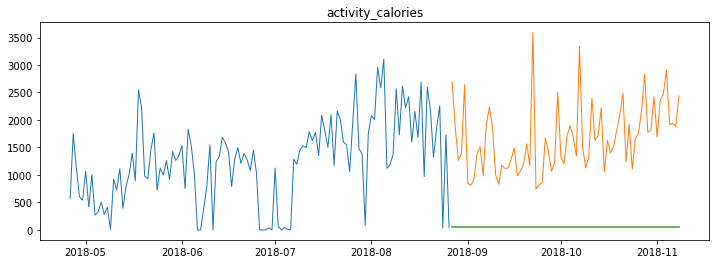

In [18]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [19]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,calories_burned,2754.0
1,last_observed_value,steps,11348.0
2,last_observed_value,distance,5.0
3,last_observed_value,floors,32.0
4,last_observed_value,mins_sedentary,711.0
5,last_observed_value,mins_light_active,193.0
6,last_observed_value,mins_fairly_active,23.0
7,last_observed_value,mins_very_active,59.0
8,last_observed_value,activity_calories,1726.0


***

**Takeaway:**

`The last vale in Train just happened to be a day where this individual stopped their regular pattern of behavior.  RMSE is very hight, average line is far from validate, model demonstrate low perdictive value`

***

<div class="alert alert-block alert-info"><b></b></div>

## Simple Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [20]:
# calories_burned Prediction
calories_burned  = round(train['calories_burned'].mean(), 2)
# steps prediction
steps = round(train['steps'].mean(), 2)
# distance prediction
distance = round(train['distance'].mean(), 2)
# floors prediction
floors = round(train['floors'].mean(), 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].mean(), 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].mean(), 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].mean(), 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].mean(), 2)
# activity_calories
activity_calories = round(train['activity_calories'].mean(), 2)

#### Apply Predictions to Observations

In [21]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-27,3261.85,6147.81,2.9,5.4,898.79,169.93,13.41,19.63,1245.7
2018-08-28,3261.85,6147.81,2.9,5.4,898.79,169.93,13.41,19.63,1245.7
2018-08-29,3261.85,6147.81,2.9,5.4,898.79,169.93,13.41,19.63,1245.7
2018-08-30,3261.85,6147.81,2.9,5.4,898.79,169.93,13.41,19.63,1245.7
2018-08-31,3261.85,6147.81,2.9,5.4,898.79,169.93,13.41,19.63,1245.7


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 570


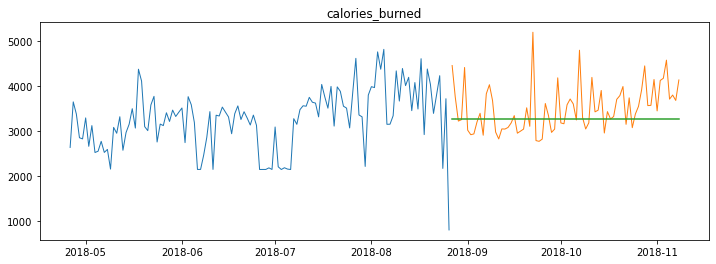

steps -- RMSE: 6271


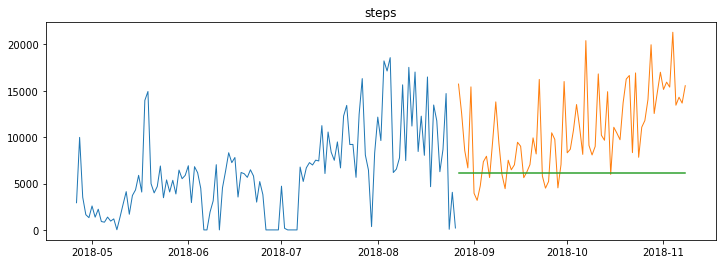

distance -- RMSE: 3


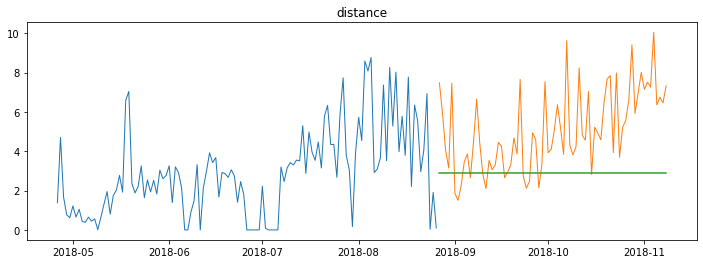

floors -- RMSE: 30


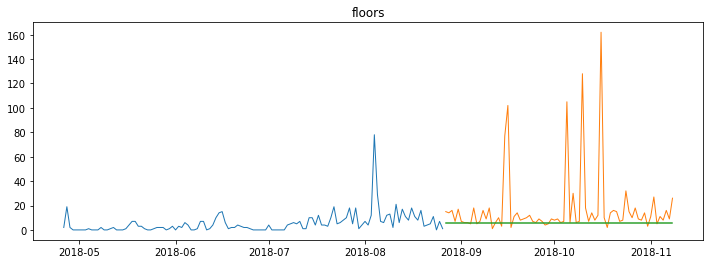

mins_sedentary -- RMSE: 205


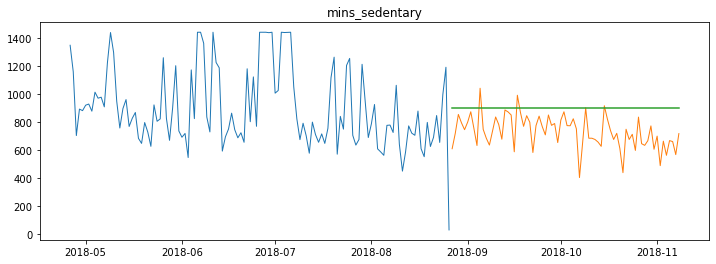

mins_light_active -- RMSE: 59


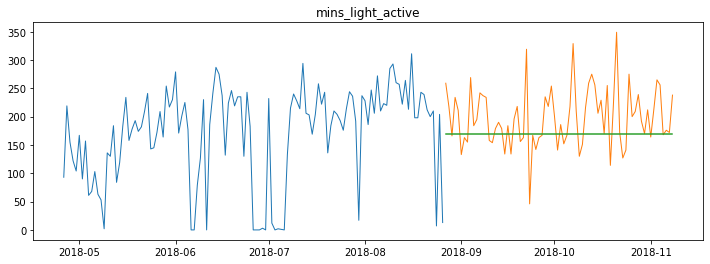

mins_fairly_active -- RMSE: 17


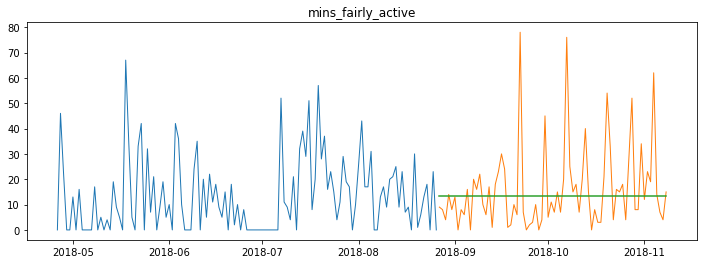

mins_very_active -- RMSE: 45


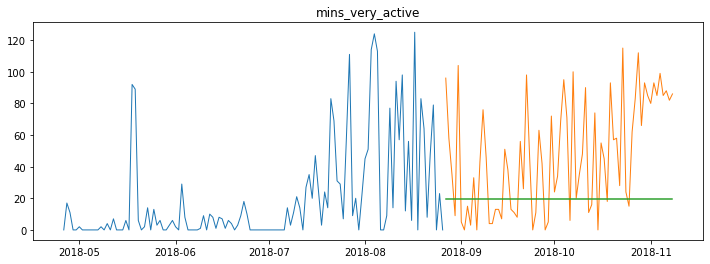

activity_calories -- RMSE: 744


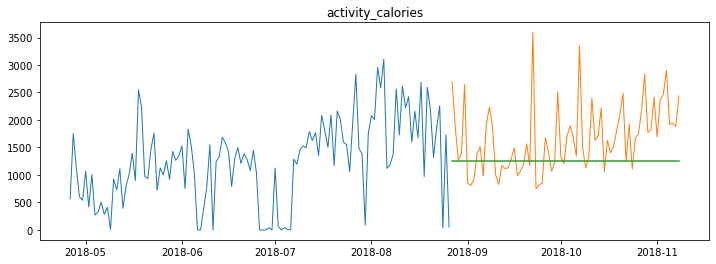

In [22]:
# Use Function to loop through columns
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df.sort_values('rmse')

,model_type,target_var,rmse
11,simple_average,distance,3.0
2,last_observed_value,distance,5.0
15,simple_average,mins_fairly_active,17.0
6,last_observed_value,mins_fairly_active,23.0
12,simple_average,floors,30.0
3,last_observed_value,floors,32.0
16,simple_average,mins_very_active,45.0
7,last_observed_value,mins_very_active,59.0
14,simple_average,mins_light_active,59.0
5,last_observed_value,mins_light_active,193.0


***

**Takeaway:**

`Simple average has lower RMSE than last observed value. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Moving Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions

In [24]:
# 30 Day Rolling average (notice monthly seasonality)

period = 30 

# calories_burned Prediction
calories_burned  = round(train['calories_burned'].rolling(period).mean()[-1], 2)
# steps prediction
steps = round(train['steps'].rolling(period).mean()[-1], 2)
# distance prediction
distance = round(train['distance'].rolling(period).mean()[-1], 2)
# floors prediction
floors = round(train['floors'].rolling(period).mean()[-1], 2)
# mins_sedentary
mins_sedentary = round(train['mins_sedentary'].rolling(period).mean()[-1], 2)
# mins_light_active
mins_light_active = round(train['mins_light_active'].rolling(period).mean()[-1], 2)
#mins_fairly_active
mins_fairly_active = round(train['mins_fairly_active'].rolling(period).mean()[-1], 2)
#'mins_very_active'
mins_very_active = round(train['mins_very_active'].rolling(period).mean()[-1], 2)
# activity_calories
activity_calories = round(train['activity_calories'].rolling(period).mean()[-1], 2)

#### Apply Predictions to Observations

In [25]:
yhat_df = pd.DataFrame({'calories_burned': [calories_burned], 
                        'steps': [steps],
                        'distance': [distance],
                        'floors': [floors],
                        'mins_sedentary': [mins_sedentary],
                        'mins_light_active': [mins_light_active],
                        'mins_fairly_active': [mins_fairly_active],
                        'mins_very_active': [mins_very_active],
                        'activity_calories': [activity_calories]},
                      index = validate.index)

yhat_df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-08-27,3664.77,9909.97,4.67,11.5,734.77,210.1,14.13,45.03,1793.47
2018-08-28,3664.77,9909.97,4.67,11.5,734.77,210.1,14.13,45.03,1793.47
2018-08-29,3664.77,9909.97,4.67,11.5,734.77,210.1,14.13,45.03,1793.47
2018-08-30,3664.77,9909.97,4.67,11.5,734.77,210.1,14.13,45.03,1793.47
2018-08-31,3664.77,9909.97,4.67,11.5,734.77,210.1,14.13,45.03,1793.47


#### Plot Actual Vs. Predicted Values

calories_burned -- RMSE: 540


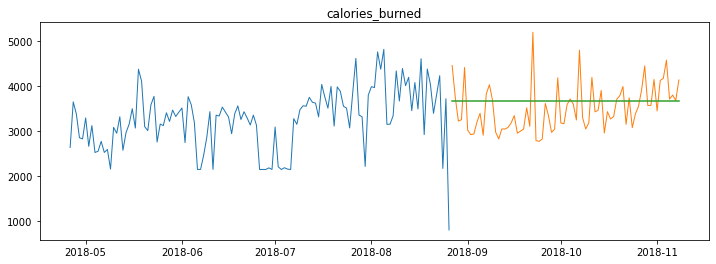

steps -- RMSE: 4380


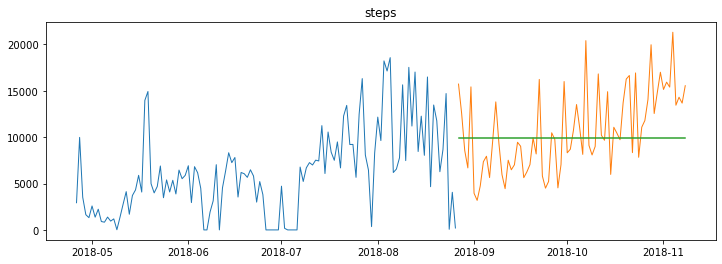

distance -- RMSE: 2


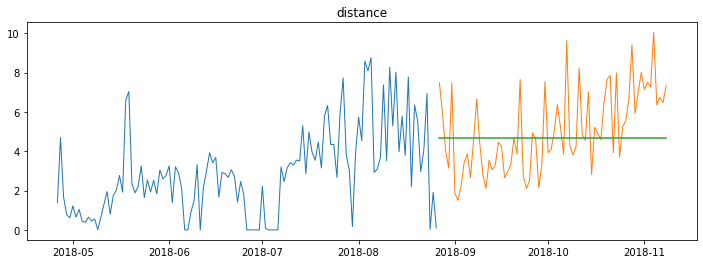

floors -- RMSE: 29


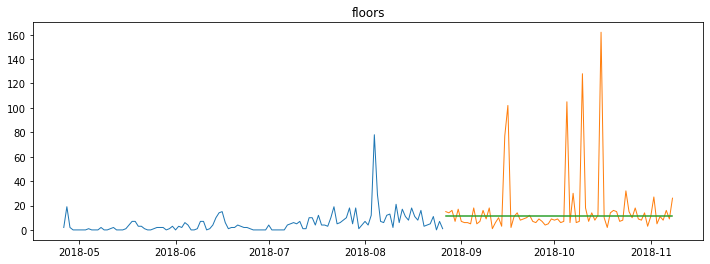

mins_sedentary -- RMSE: 116


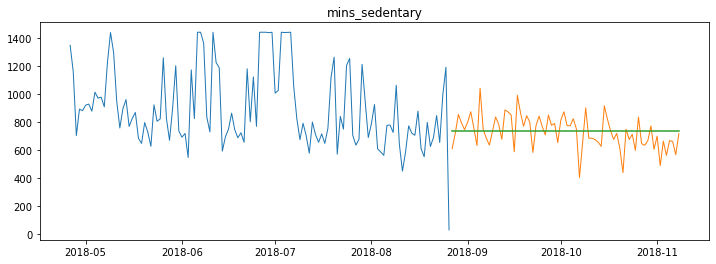

mins_light_active -- RMSE: 53


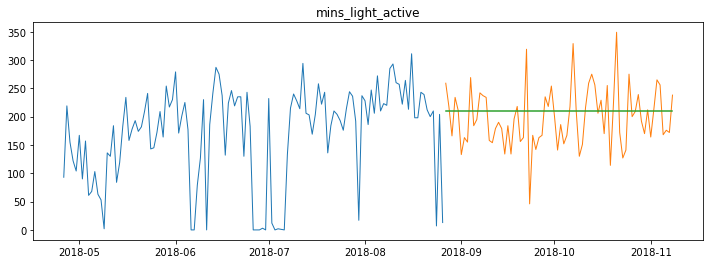

mins_fairly_active -- RMSE: 16


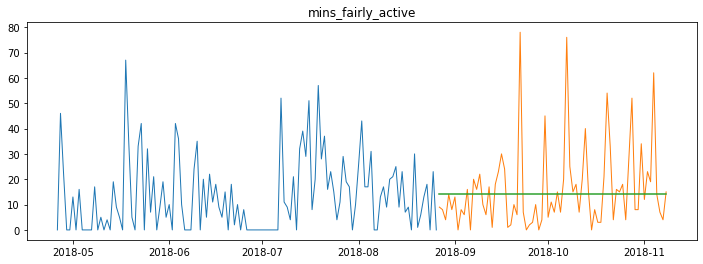

mins_very_active -- RMSE: 35


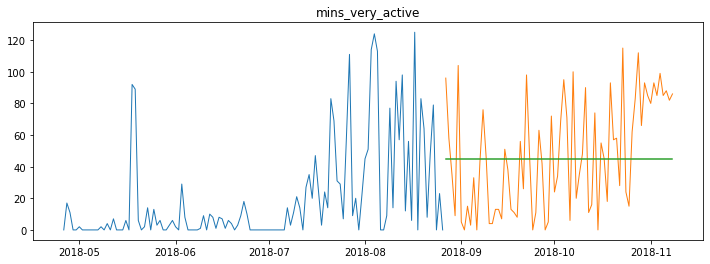

activity_calories -- RMSE: 630


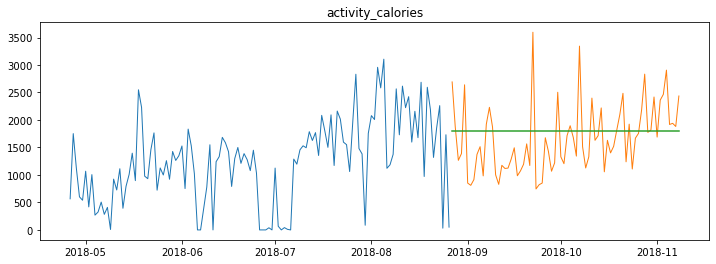

In [26]:
for col in train.columns:
    plot_and_eval(col)

#### Evauate

In [27]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df.sort_values('rmse')

,model_type,target_var,rmse
20,30d_moving_avg,distance,2.0
11,simple_average,distance,3.0
2,last_observed_value,distance,5.0
24,30d_moving_avg,mins_fairly_active,16.0
15,simple_average,mins_fairly_active,17.0
6,last_observed_value,mins_fairly_active,23.0
21,30d_moving_avg,floors,29.0
12,simple_average,floors,30.0
3,last_observed_value,floors,32.0
25,30d_moving_avg,mins_very_active,35.0


***

**Takeaway:**

`30 Day moving average has lower RMSE than simple average. This model has the best perdictive value so far`

***

<div class="alert alert-block alert-info"><b></b></div>

## Holt's Linear Trend

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions
#### Apply Predictions to Observations
#### Plot Actual Vs. Predicted Values
#### Evauate

<div class="alert alert-block alert-info"><b></b></div>

## Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions
#### Apply Predictions to Observations
#### Plot Actual Vs. Predicted Values
#### Evauate

<div class="alert alert-block alert-info"><b></b></div>